<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/Chapter_4_Dynamic_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#@title Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (8, 7)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

## Chapter 4. Dynamic Programming



### 4.1 Policy Evaluation

---

Let's reproduce Figure 4.1 from the book (page 77). We want to implement policy iteration and show that the policy converges to the optimal policy -- satisfying the Bellman optimality equations -- within a finite number of steps. ($v_{k} \to v_\pi$ as $k \to \infty$).

We follow the in-place iterative policy evaluation algorithm on page 75.


In [33]:
def is_terminal(state: np.array) -> bool:
    '''
    Assume that upper left and bottom right are terminal states. 
    
    Args:
        state: the (x, y) coordinates of the grid world.
    Return:
        Whether the state is a terminal state (True) or not (False).
    '''
    x, y = state
    if (x == 0 and y == 0) or (x == N_ROWS-1 and y == N_COLS-1): 
        return True
    else:
        return False

In [78]:
def step(state: np.array, action: int) -> Tuple[np.array, int]:
    '''
    Take a step in the small grid world.

    Args:
        state: the (x, y) coordinates; current position of the agent.
        action: the selected action.
    Returns:
        next_state: the position of the agent after taking the action in the state.
        reward: the reward signal optained.
    '''
    # Check if the agent is in a terminal state
    if is_terminal(state):
        return (
            state, 0
        )
    
    # Take action
    next_state = state + action

    # make sure we stay inside our grid world
    x, y = next_state
    if x < 0 or (x > N_ROWS-1) or y < 0 or (y > N_COLS-1):
        next_state = state     
    reward = -1

    #print(f'State: {state}')
    #print(f'Next state: {next_state}')

    return next_state, reward

In [69]:
# Create a simple grid world
N_ROWS = 4
N_COLS = 4

# Left, right, up, down
ACTIONS = (
    np.array([0, -1]),
    np.array([0, 1]),
    np.array([1, 0]),
    np.array([-1, 0]),
)

# Use a random policy; all actions are equally likely
PI_RAND = 1 / len(ACTIONS)

# Parameters
TERMINATE = False
THETA = 1e-3
iters = 0
GAMMA = 1

# Create grid to track the value of each state
new_state_values = np.zeros((N_ROWS, N_COLS))

while not TERMINATE:
    
    # Current is new and previous is old
    state_values = new_state_values.copy()
    old_state_values = state_values.copy()

    # Loop for each state s 
    for row_i in range(N_ROWS):
        for col_i in range(N_COLS):
            state_value = 0 
            for action in ACTIONS:
                state = np.array([row_i, col_i])

                next_state, reward = step(state, action)

                # Add value to state
                state_value += PI_RAND * (reward + GAMMA * state_values[next_state.to_list()])

            # Update state value
            new_state_values[row_i, col_i] = state_value
        
    iters += 1

    DELTA = abs(old_state_values - new_state_values).max()
    
    # Stop when meets criteria
    if DELTA < THETA:
        TERMINATE = True

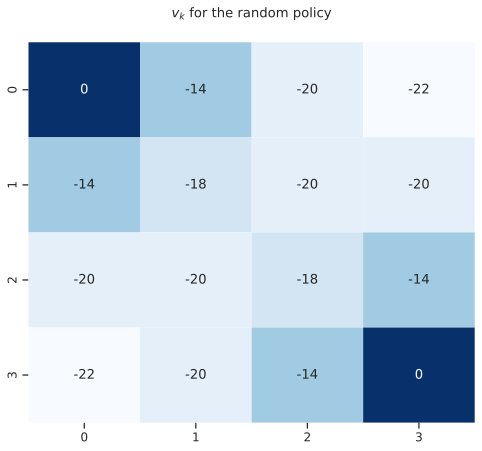

In [79]:
sns.heatmap(state_values, annot=True, cbar=False, cmap='Blues');
plt.title(r'$v_{k}$ for the random policy', y=1.05);

### 4.2 [ ... ]

---

### 3.3 [ ... ]